<a href="https://colab.research.google.com/github/PHYS486-S22/PHYS486-S22/blob/main/SampleNotebooks/ProjectTwo_Relaxation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make the usual imports


In [55]:
#import numpy, scipy, and math libraries
import numpy as np
import math

#import matplotlib so that we can make plots; import common subroutines and give them compact names
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib inline

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 18, 12
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

# Relaxation method functions

First, a generic function to perform one relaxation step over an input grid of arbitrary size

In [56]:
#a function to loop through a grid, and generate a copy where the value of each cell 
#corresponds to the average of its neighbor's initial values.
def loopCells(grid, finishGrid, dimensions, charges = None):
 
    #use two loops to loop over rows and columns
    for i in range(1,dimensions[0]-1):
        for j in range(1,dimensions[1]-1):

            # check if there are any charges in this grid.
            if (np.any(charges) != 0.):
                
                #if there are charges in the grid, check if there are any in this particular cell.
                if (charges[i,j] != 0.):

                  #if there is a charge in this cell, hold the voltage fixed at the voltage indicated for the charge.
                  finishGrid[i,j] = charges[i,j]

                #if there aren't charges in this cell, relax as usual.
                else:
                  finishGrid[i,j] = 0.25 * (grid[i-1,j] + grid[i+1,j] + grid[i,j-1] + grid[i,j+1] )

            #if there aren't charges in the grid, relax everywhere as usual.
            else:
                finishGrid[i,j] = 0.25 * ( grid[i-1,j] + grid[i+1,j] + grid[i,j-1] + grid[i,j+1] )
 
    return finishGrid

Now, a slightly less generic funtion that relaxes a grid until it meets an input (relative estimated) error criteria, and allows for inserting charges into the grid (ie, imposes boundary conditions inside as well as outside of the grid).

In [57]:
#write a function that relaxes a 2-D grid until a final error Criteria is reached
def relaxGrid(grid, errorCriteria, limit = None, local = None, charges = None):
    
    #find the size of the array
    dimensions = grid.shape

    #copy the grid into a second array so we can populate without replacement
    #NOTE -- this is important, because if we don't do it, we'll accidentally 
    #be implementing the Gauss-Seidel method because of the way that python
    #defaults to referencing variables rather than creating brand new instances!!!
    finishGrid = np.copy(grid)
    
    #initialize trackers for the number of iterations performed
    #and the average change per site
    errorTracker = 100*errorCriteria
    iterations = 0
    
    #set the limit on the minimum number of iterations to perform
    if (limit == None):
        useLimit = 5*dimensions[0]
    else:
        useLimit = limit
    
    #enter the while loop if the change per site is less than the convergence criteria
    while (errorTracker > errorCriteria):
        
        #increase our iteration counter
        iterations = iterations+1

        #iterate our relaxation method forward one step; store the answer in finishGrid, our copy 
        #of the original grid that was passed to the function.
        if (np.any(charges) != 0):
            finishGrid = loopCells(grid, finishGrid, dimensions, charges = charges)
        else:            
            finishGrid = loopCells(grid, finishGrid, dimensions)
        
        #test if we've passed our minimum number of iterations.  If so, calculate a genuine
        #value of errorTracker; if not, continue to use our inflated value.
        if (iterations > useLimit):
            errorTracker = np.sum( np.absolute(grid[1:dimensions[0]-2,1:dimensions[1]-2] - finishGrid[1:dimensions[0]-2,1:dimensions[1]-2] ))/( (dimensions[0]-2)*(dimensions[1]-2) )
        else:
            errorTracker = errorCriteria*100

        #check if the average change per site (which is only a real number if we've satisified our 
        #iteration limit) is still larger than our convergence criteria; if so, do another iteration
        #but this time calculate the average from finishGrid, and store back in our original grid 
        #array (so that we're ready to start the loop over again)
        if (errorTracker > errorCriteria):
            if (np.any(charges) != 0):
                grid = loopCells(finishGrid, grid, dimensions, charges = charges)
            else:
                grid = loopCells(finishGrid, grid, dimensions)
        
            #advance our iteration counter by 1 (inside this if statement, so that we don't advance
            #the counter if we have already satisfied our change per site criteria and are about to exit
            #the larger while loop)
            iterations = iterations+1
        
        if ( (iterations % 50) == 0):
           print('i: ',iterations, '   error: ', errorTracker)
        
    #return all our hard fought values back to the larger world!    
    return finishGrid, iterations

# Set up a grid with boundary and initial conditions

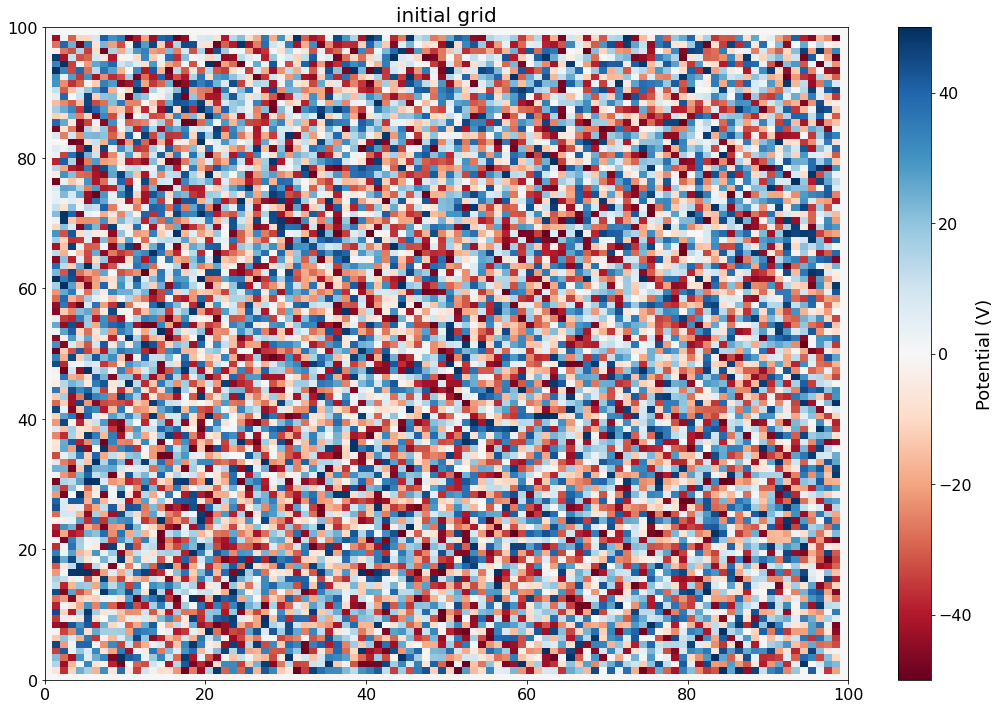

In [58]:
#define the size of our relaxation grid
rows = 100
columns = 100

#populate the grid, either with a uniform initial value or with random values
#(only one of the two lines below can be used at a time.)
#grid = np.ones([rows,columns])*25
grid = np.random.rand(rows,columns)*100-50

#set boundary conditions
grid[0,:] = 0
grid[:,0] = 0
grid[:,columns-1] = 0
grid[rows-1,:] = 0

#make a plot to show our initial conditions as a pixellated, colored contour map.
z_min, z_max = grid.min(), grid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), grid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('initial grid' )
plt.savefig('100x100_initial_grid.jpg', bbox_inches='tight')    

Also define the geometry of the capacitor plates in this space that we want to model

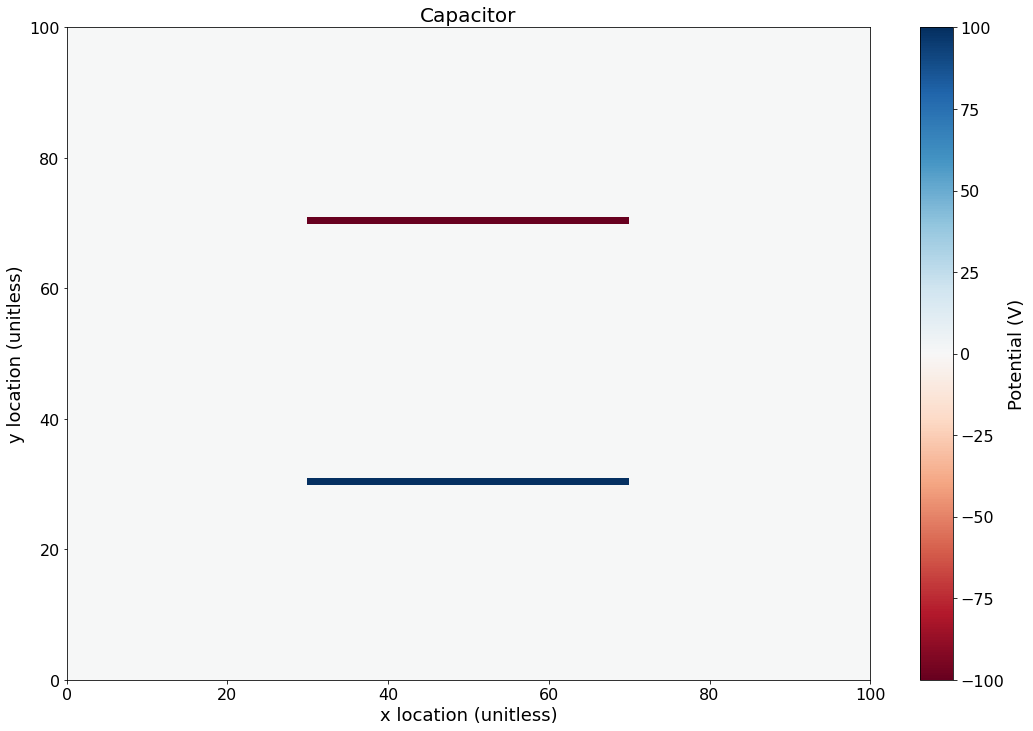

In [59]:
#define the geometry of our capacitor plates
lower_plate = 30
upper_plate = 70
left_edge = 30
right_edge = 70

#create an array that is matched to the size of our grid, where we can 
#store information about the voltage we want to hold the capacitor's plates at
charges = np.zeros([rows,columns])
charges[lower_plate,left_edge:right_edge] = 100
charges[upper_plate,left_edge:right_edge] = -100

#display the charges
z_min, z_max = charges.min(), charges.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), charges, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.xlabel('x location (unitless)')
plt.ylabel('y location (unitless)')
plt.colorbar(label = 'Potential (V)')
plt.title('Capacitor')
plt.savefig('Initial_Capacitor.jpg', bbox_inches='tight')  

## IDENTIFY THE PROPERTIES THE SYSTEM + FIELD SHOULD HAVE!

Note that we haven't actually given much indication of the physical properties of our capacitor in the cell above. 

(I say 'much' rather than 'any' because the label on the color bar does reveal that the value of the charges array should have units of volts)

Let's do so now, and identify how we can translate from our numerical units into actual physical values.

### spatial constraints
Assume the capacitor's plates are 20 cm across, and separated by 20 cm as well. 

what is the width of each grid cell?  That is, what are the physical units of $\Delta$x and $\Delta$y?

#### width per grid cell: XXX cm   <--- update this!!!!

### expected E-field

Based on the potential difference and separation between the plates, what do you expect the E-field in the capacitor to be?

#### E-field: magnitude and direction  <--- update this!!!!

# Actually relax the grid



i:  50    error:  40.0
i:  100    error:  40.0
i:  150    error:  40.0
i:  200    error:  40.0
i:  250    error:  40.0
i:  300    error:  40.0
i:  350    error:  40.0
i:  400    error:  40.0
i:  450    error:  40.0
i:  500    error:  40.0


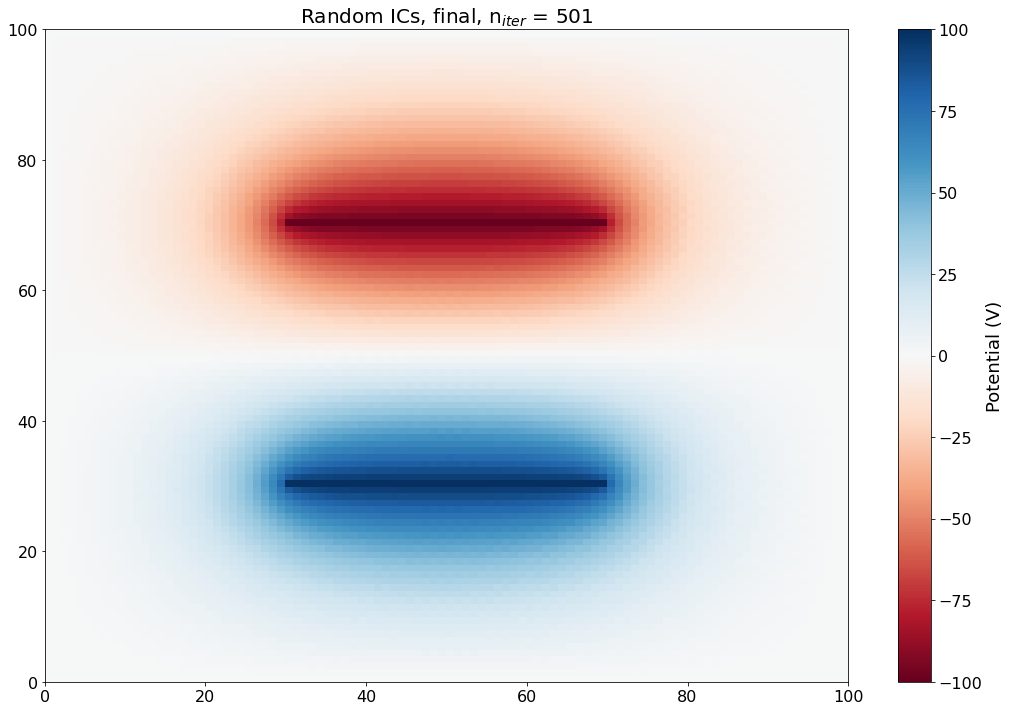

In [60]:
#save a copy of the input grid
initialGrid = np.copy(grid)

#perform the relaxation method
finalGrid, iterations = relaxGrid(grid, 0.4, limit = 500, charges = charges)

#plot the final grid
z_min, z_max = finalGrid.min(), finalGrid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
plt.savefig('100x100_final_grid.jpg', bbox_inches='tight')    

In [61]:
#find the electric field by calculating the gradient in the potential 
#at the location of each cell (by calculating the change in potential between 
#each cell's neighbors)

#a function to loop through a grid, and generate a copy where the value of each cell 
#corresponds to the average of its neighbor's initial values.
def findField(grid):
 
    #find the size of the grid we're dealing with
    xdimension = len(grid[0,:])
    ydimension = len(grid[:,0])
    
    #construct a 2-D grid of X and Y positions
    X, Y = np.meshgrid(np.arange(0,xdimension,1),np.arange(0,ydimension,1))
    
    #set up 2-D arrays for calculating the difference across each cell 
    #in the X and Y direction
    deltax = np.zeros([xdimension, ydimension])
    deltay = np.zeros([xdimension, ydimension])
        
    #use two loops to loop over rows and columns
    for i in range(1,xdimension-1):
        for j in range(1,ydimension-1):

            #calculate the potential difference across each cell, in each direction
            deltax[i,j] = -(grid[i,j+1] - grid[i,j-1])
            deltay[i,j] = -(grid[i+1,j] - grid[i-1,j])
 
    #return the X Y positions of the grid, and the slopes in the x and y directions, 
    #which we'll be able to recombine to make vectors.
    return X, Y, deltax, deltay

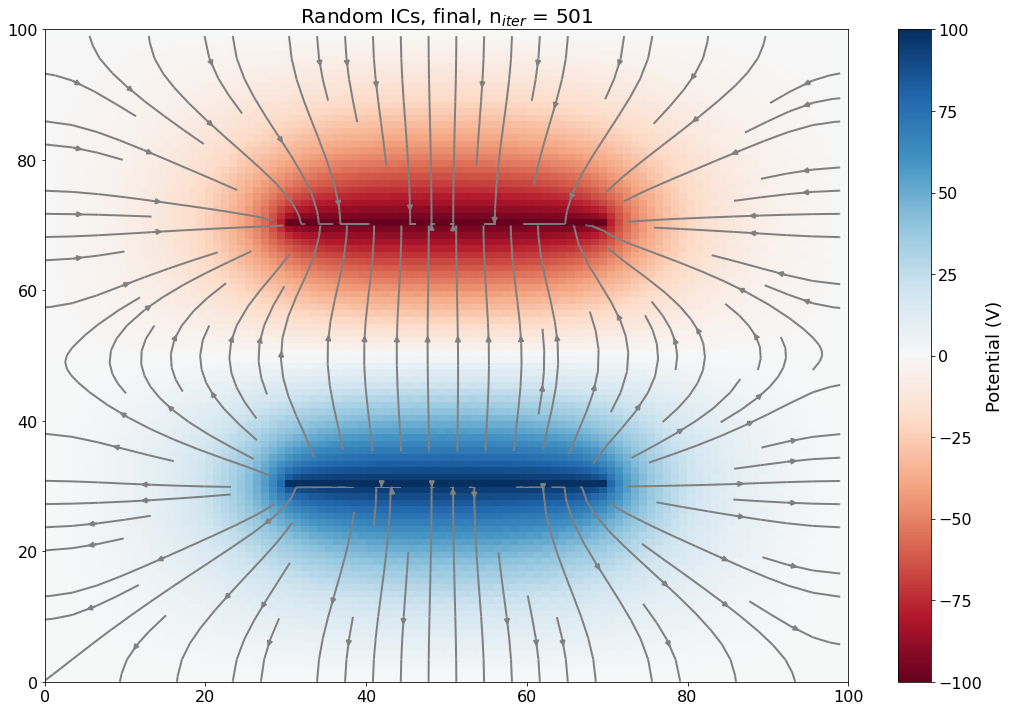

In [62]:
#calculate the e-field as the gradient of the potential at each point in the grid.
#natural units of ex and ey are the potential difference across two cells.
X, Y, ex, ey = findField(finalGrid)

CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
plt.streamplot(X, Y, ex, ey, density=1, color = 'grey')
plt.savefig('100x100_final_grid_withField.jpg', bbox_inches='tight')    

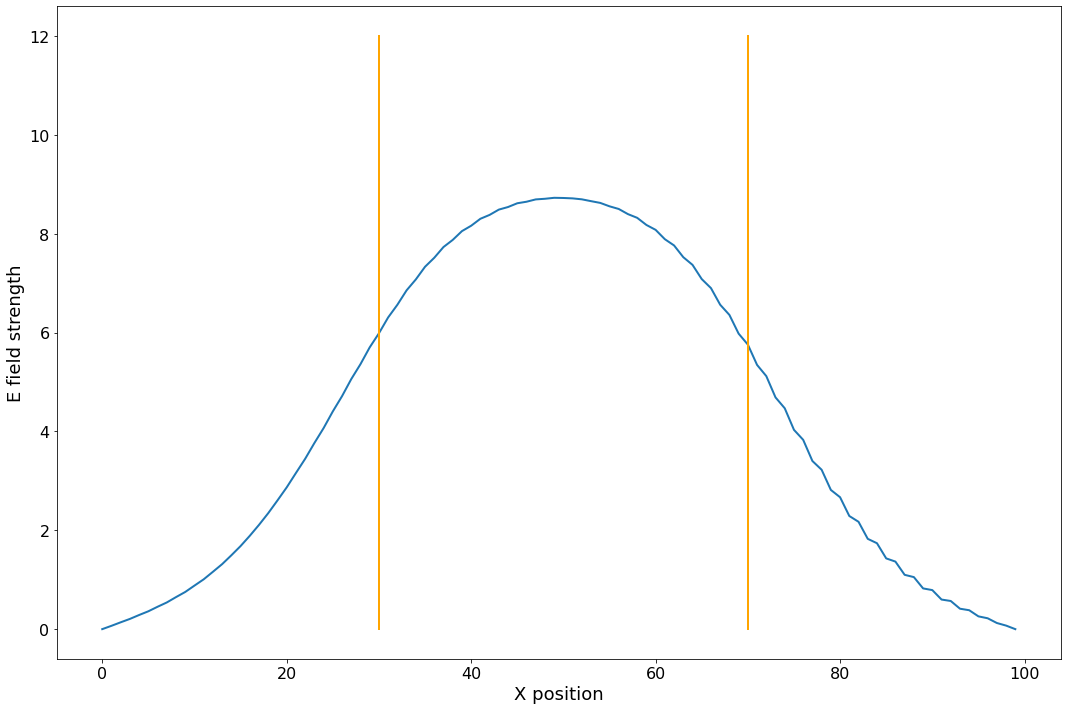

In [63]:
#plot the magnitude of the E-field in the y-direction, across the mid-plane of the grid.
plt.plot(ey[50,:])

#plot lines showing the edges of the capacitor plates
plt.plot([left_edge,left_edge], [0,12], color='orange')
plt.plot([right_edge,right_edge], [0,12], color='orange')
plt.xlabel('X position')
plt.ylabel('E field strength')
plt.show()

### ATTACHING PHYSICAL UNITS TO THE E-FIELD
The E-field calculation above fundamentally measures the change in potential across two cells at a time.  What does this make the natural units of the plot above?

#### Original units of 'E field strength' in plot above: XXXX <-- Update this!!!

It would be better to convert the plot above to report the E-field strength in the usual units of V/m.  What value do we need to multiply the values in the ey array by to get E-field magnitudes in these units?

#### value to multiply ey by to get field strength in units of V/m: XXXX <-- update this!!!!

Now go ahead and multiply ey by this value and remake the plot above.  Does the peak field strength match your estimate from earlier in the notebook?  Is there any *physical* reason why you might expect it to differ?

### Compare to a wider capacitor.

Below are cells that repeat the calculations above. 

### MODIFY THESE CELLS TO SIMULATE A WIDER (40 cm) CAPACITOR 

Re-relax the system, and see how the e-field strength compares

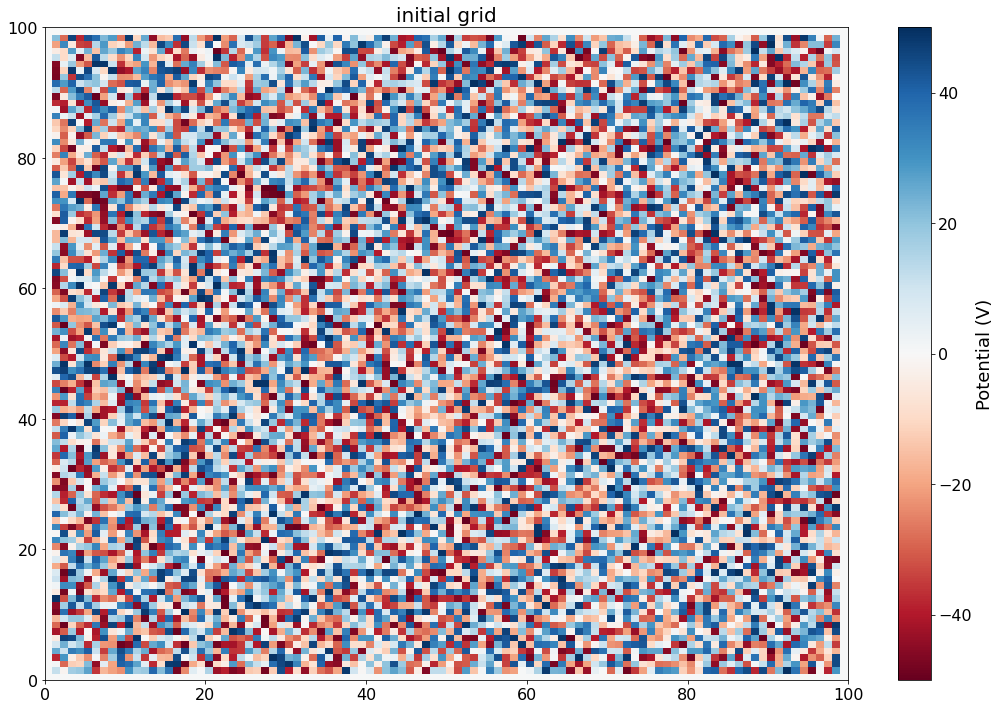

In [64]:
#define the size of our relaxation grid
rows = 100
columns = 100

#populate the grid, either with a uniform initial value or with random values
#(only one of the two lines below can be used at a time.)
#grid = np.ones([rows,columns])*25
grid = np.random.rand(rows,columns)*100-50

#set boundary conditions
grid[0,:] = 0
grid[:,0] = 0
grid[:,columns-1] = 0
grid[rows-1,:] = 0

#make a plot to show our initial conditions as a pixellated, colored contour map.
z_min, z_max = grid.min(), grid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), grid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('initial grid' )
plt.savefig('Grid_for_wider_Capacitor.jpg', bbox_inches='tight')    

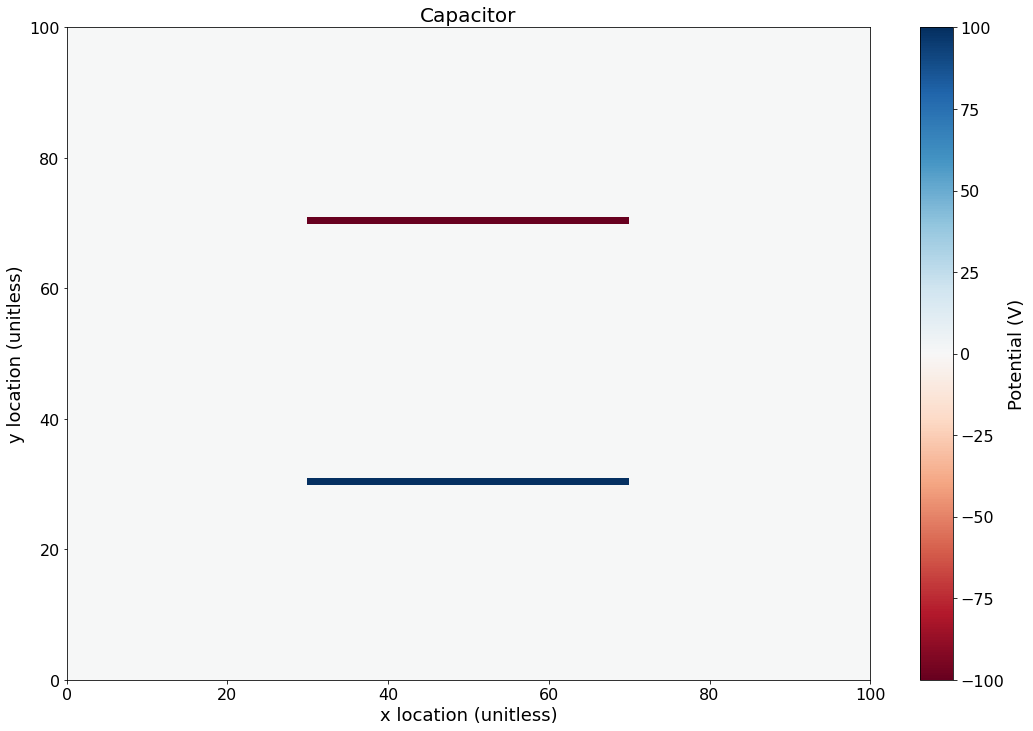

In [65]:
#define the geometry of our capacitor plates
lower_plate = 30
upper_plate = 70
left_edge = 30
right_edge = 70

#create an array that is matched to the size of our grid, where we can 
#store information about the voltage we want to hold the capacitor's plates at
charges = np.zeros([rows,columns])
charges[lower_plate,left_edge:right_edge] = 100
charges[upper_plate,left_edge:right_edge] = -100

#display the charges
z_min, z_max = charges.min(), charges.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), charges, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.xlabel('x location (unitless)')
plt.ylabel('y location (unitless)')
plt.colorbar(label = 'Potential (V)')
plt.title('Capacitor')
plt.savefig('Initial_Wider_Capacitor.jpg', bbox_inches='tight')  

i:  50    error:  40.0
i:  100    error:  40.0
i:  150    error:  40.0
i:  200    error:  40.0
i:  250    error:  40.0
i:  300    error:  40.0
i:  350    error:  40.0
i:  400    error:  40.0
i:  450    error:  40.0
i:  500    error:  40.0


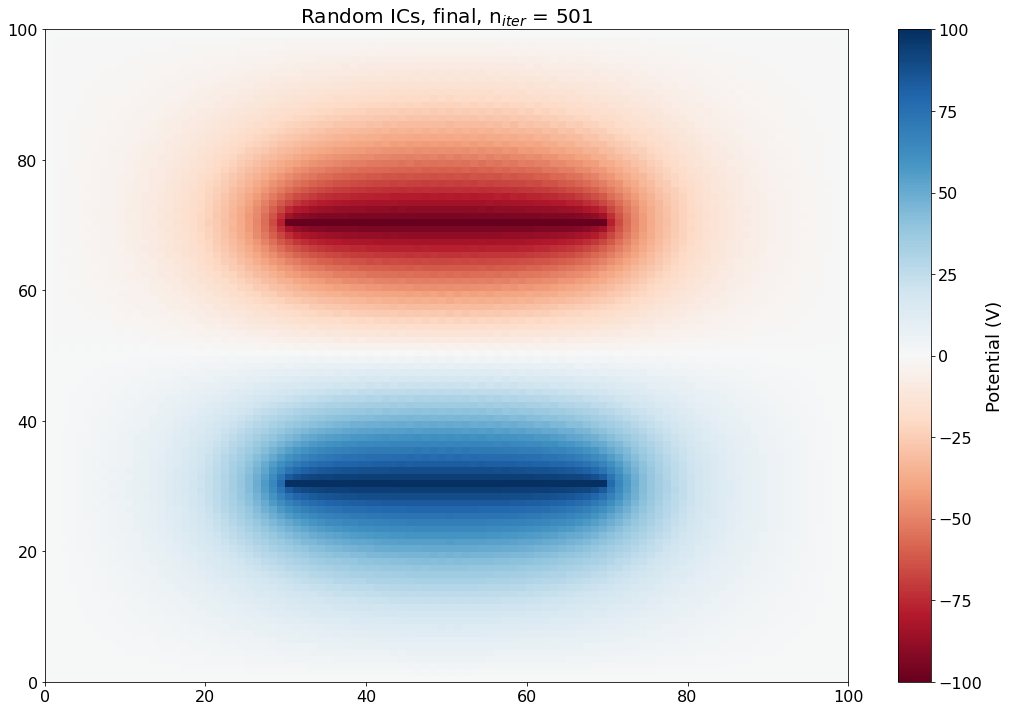

In [66]:
#save a copy of the input grid
initialGrid = np.copy(grid)

#perform the relaxation method
finalGrid, iterations = relaxGrid(grid, 0.4, limit = 500, charges = charges)

#plot the final grid
z_min, z_max = finalGrid.min(), finalGrid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
plt.savefig('100x100_final_Wider_Capactitor.jpg', bbox_inches='tight')    

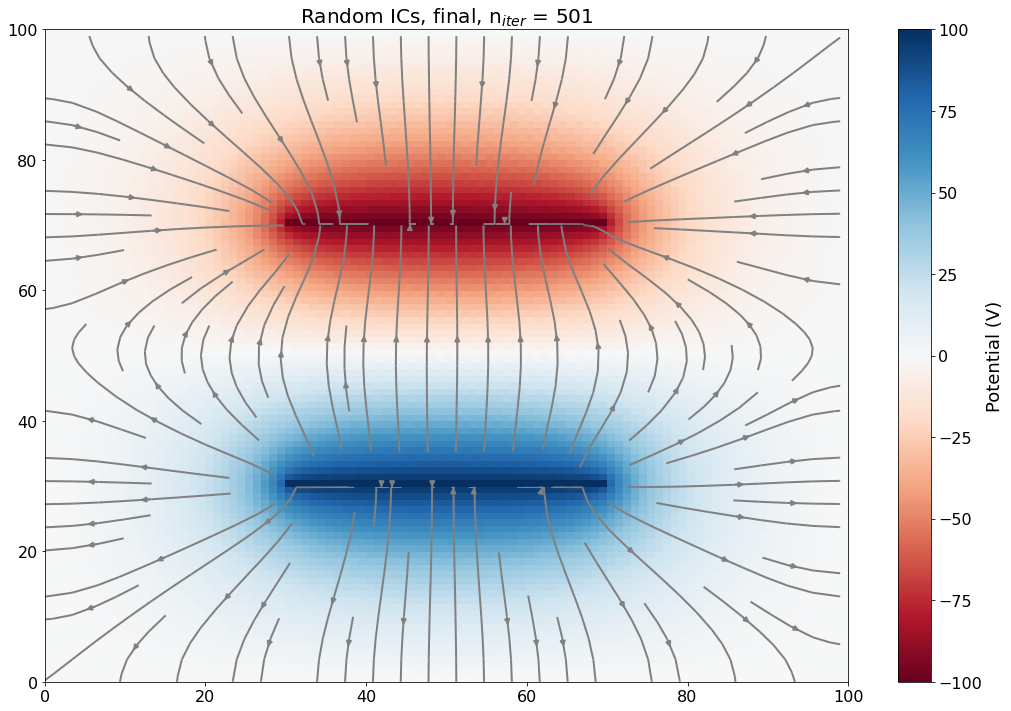

In [67]:
#calculate the e-field as the gradient of the potential at each point in the grid.
#natural units of ex and ey are the potential difference across two cells.
X, Y, ex, ey = findField(finalGrid)

CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
plt.streamplot(X, Y, ex, ey, density=1, color = 'grey')
plt.savefig('100x100_final_Wider_withField.jpg', bbox_inches='tight')    

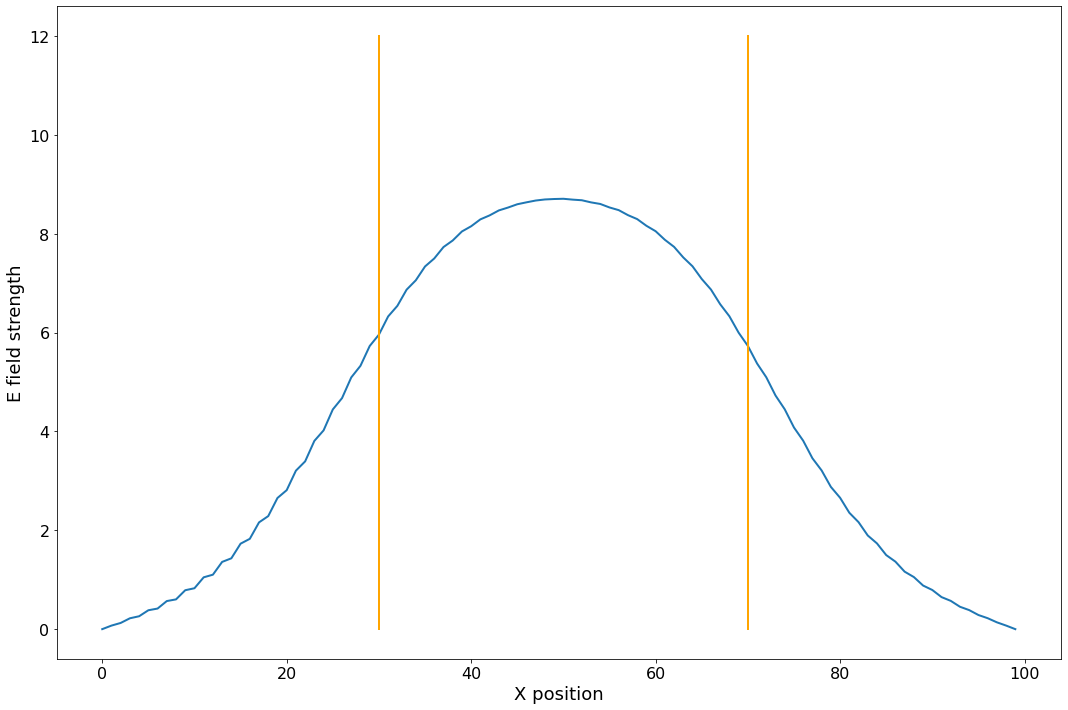

In [68]:
#plot the magnitude of the E-field in the y-direction, across the mid-plane of the grid.
plt.plot(ey[50,:])

#plot lines showing the edges of the capacitor plates
plt.plot([left_edge,left_edge], [0,12], color='orange')
plt.plot([right_edge,right_edge], [0,12], color='orange')
plt.xlabel('X position')
plt.ylabel('E field strength')
plt.show()

#### Wider GRID

Now let's use the same capacitor as in our first attempt, but modify the grid we are relaxing on to make it larger (which will take longer to solve!).

Since this will take longer to solve, I've made this modification for you: I've modified the cells below to use a 200x200 grid, but with the same spatial scale and capacitor as in the first simulation.

### How many more cells are in this grid?  What do you expect that to do to the runtime of the relaxation step?

(note that google colab gives a little counter at the bottom of a notebook showing how long the current cell has been running.  You may want to re-run one of the cells above that relaxes a 100x100 grid, and use that time along with your estimated inflation factor to identify how long this calculation may take to run).

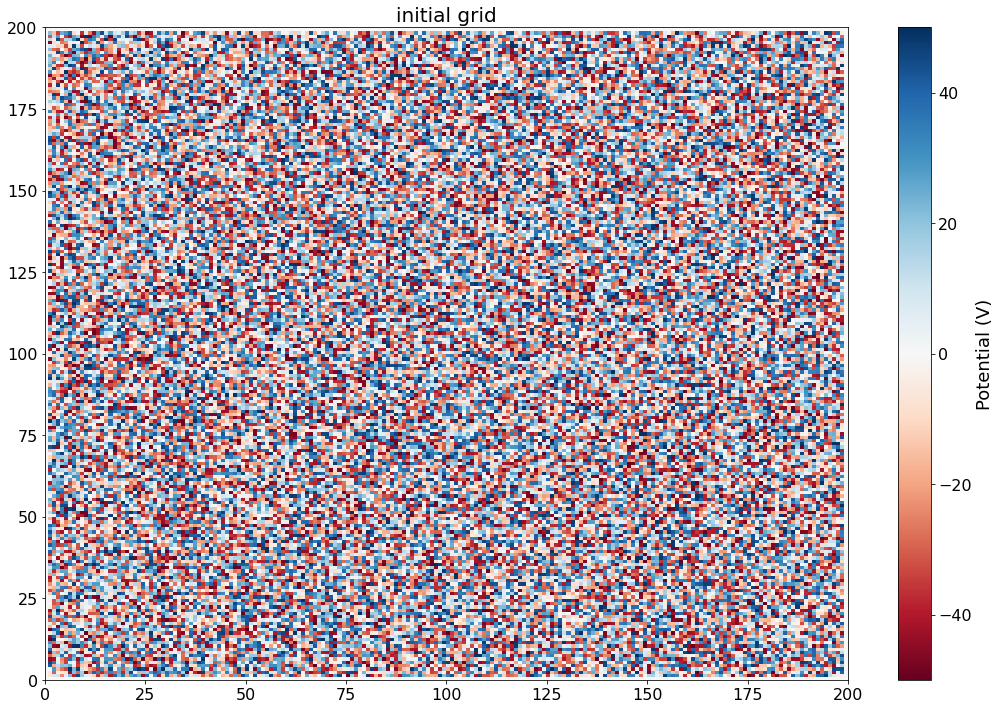

In [69]:
#define the size of our relaxation grid
rows = 200
columns = 200

#populate the grid, either with a uniform initial value or with random values
#(only one of the two lines below can be used at a time.)
#grid = np.ones([rows,columns])*25
grid = np.random.rand(rows,columns)*100-50

#set boundary conditions
grid[0,:] = 0
grid[:,0] = 0
grid[:,columns-1] = 0
grid[rows-1,:] = 0

#make a plot to show our initial conditions as a pixellated, colored contour map.
z_min, z_max = grid.min(), grid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), grid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('initial grid' )
plt.savefig('Grid_for_wider_Capacitor.jpg', bbox_inches='tight')    

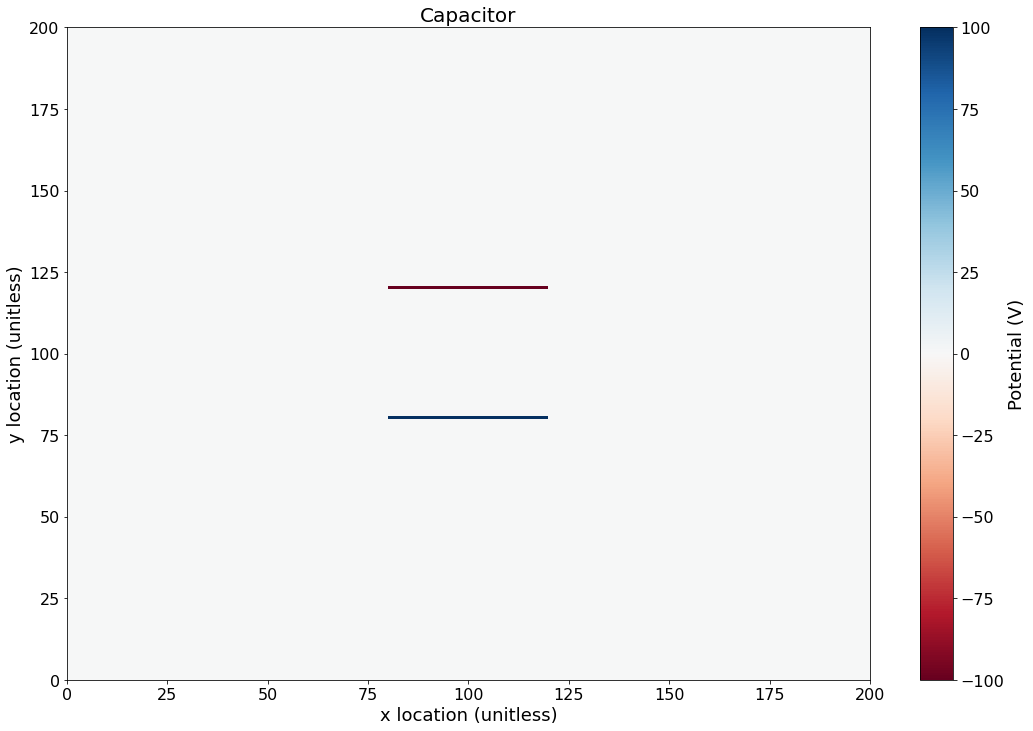

In [70]:
#define the geometry of our capacitor plates
lower_plate = 80
upper_plate = 120
left_edge = 80
right_edge = 120

#create an array that is matched to the size of our grid, where we can 
#store information about the voltage we want to hold the capacitor's plates at
charges = np.zeros([rows,columns])
charges[lower_plate,left_edge:right_edge] = 100
charges[upper_plate,left_edge:right_edge] = -100

#display the charges
z_min, z_max = charges.min(), charges.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), charges, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.xlabel('x location (unitless)')
plt.ylabel('y location (unitless)')
plt.colorbar(label = 'Potential (V)')
plt.title('Capacitor')
plt.savefig('Initial_Wider_Capacitor.jpg', bbox_inches='tight')  

i:  50    error:  40.0
i:  100    error:  40.0
i:  150    error:  40.0
i:  200    error:  40.0
i:  250    error:  40.0
i:  300    error:  40.0
i:  350    error:  40.0
i:  400    error:  40.0
i:  450    error:  40.0
i:  500    error:  40.0
i:  550    error:  0.4201688860163017


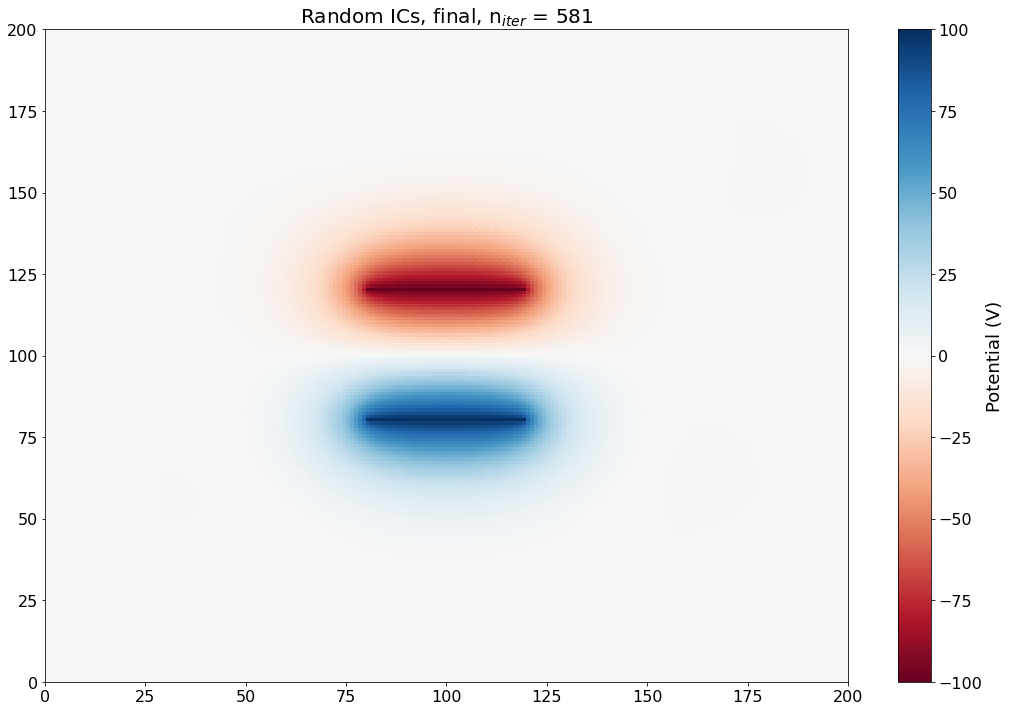

In [71]:
#save a copy of the input grid
initialGrid = np.copy(grid)

#perform the relaxation method
finalGrid, iterations = relaxGrid(grid, 0.4, limit = 500, charges = charges)

#plot the final grid
z_min, z_max = finalGrid.min(), finalGrid.max()
CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
plt.savefig('100x100_final_Wider_Grid.jpg', bbox_inches='tight')    

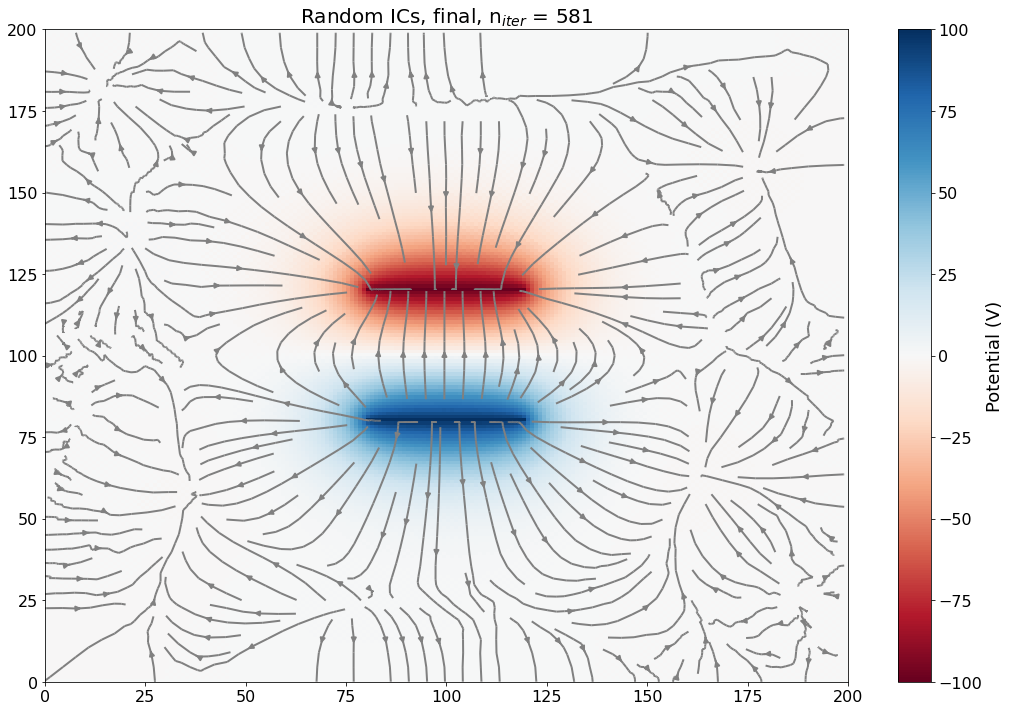

In [75]:
#calculate the e-field as the gradient of the potential at each point in the grid.
#natural units of ex and ey are the potential difference across two cells.
X, Y, ex, ey = findField(finalGrid)

CS = plt.pcolor(np.arange(0,columns+1), np.arange(0,rows+1), finalGrid, cmap='RdBu', vmin=z_min, vmax=z_max)
plt.colorbar(label = 'Potential (V)')
plt.title('Random ICs, final, n$_{iter}$ = '+str(iterations) )
plt.streamplot(X, Y, ex, ey, density=1.5, color = 'grey')
plt.savefig('100x100_final_Wider_Grid_withField.jpg', bbox_inches='tight')    

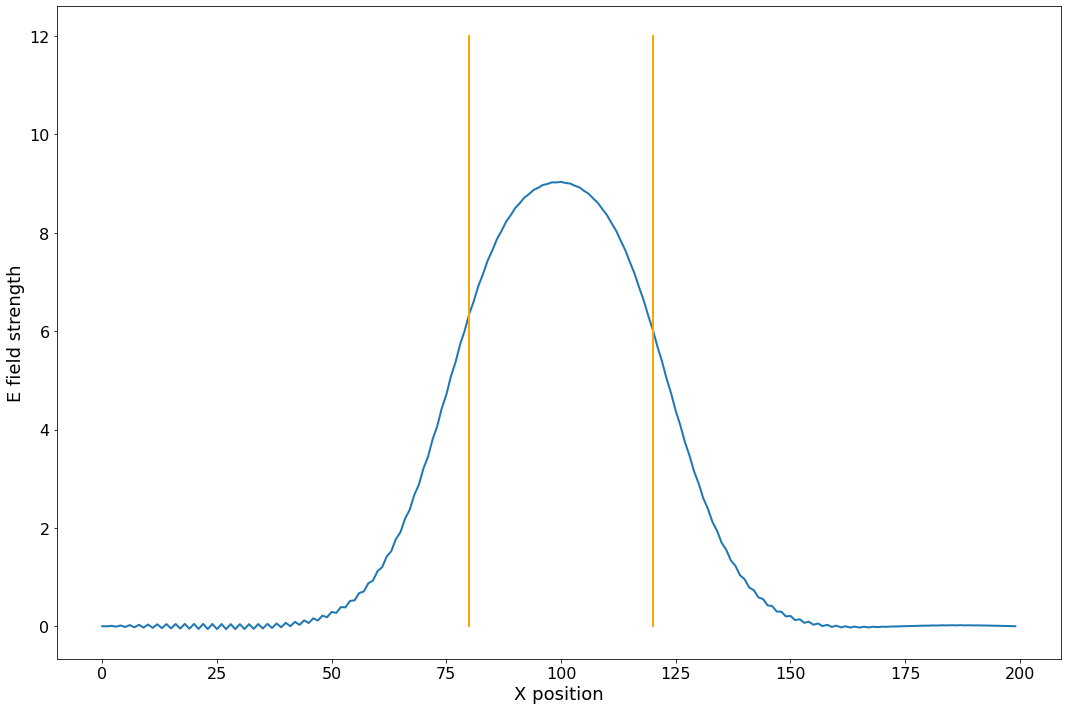

In [73]:
#plot the magnitude of the E-field in the y-direction, across the mid-plane of the grid.
plt.plot(ey[100,:])

#plot lines showing the edges of the capacitor plates
plt.plot([left_edge,left_edge], [0,12], color='orange')
plt.plot([right_edge,right_edge], [0,12], color='orange')
plt.xlabel('X position')
plt.ylabel('E field strength')
plt.show()

You should now have three plots showing the magnitude of the E-field in capacitor's mid-plane in a set of consistent units.

Examine three properties of each plot:
- the strength of the field in the center of the capacitor
- the slope of the E-field where the capacitor's plates end.
- the slope of the E-field at the edge of the grid.

#### write a paragraph explaining what your plots tell you about how those three properties are affected by changes in the size of the capacitor, and separately, the size of the simulation grid.

#### That's it!  Now save your notebook back to your private github repository, in a new 'Project Two' folder.